In [2]:
import pandas as pd
import numpy as np
import os
import ast
import matplotlib.pyplot as plt
%matplotlib inline

## Load the Frame

In [3]:
# donwload and filter columns of interest
historic_raw = pd.read_csv("../../data/raw/historic/final.csv")
columns = [x for x in historic_raw.columns if x in ["suburbs", "year", "quarter"]] + \
          [x for x in historic_raw.columns if "housing" in x] + \
          [x for x in historic_raw.columns if "economic" in x]
historic_raw = historic_raw[columns]
historic_raw.head(3)

,suburbs,year,quarter,housing: type,housing: beds,housing: count,housing: median,housing: previous 2 years,housing: avg 2 years,economic: median age of earners,economic: median income,economic: top 5% suburb,economic: top 1% suburb,economic: gini coefficient,economic: trimmed mean quarterly,economic: variable interest rate,economic: gdp quarterly,economic: gdp per capita quarterly,economic: number of earners
0,Albert Park-Middle Park-West St Kilda,2002.0,1.0,all,all,1332.0,300.0,"[260.0, 270.0, 275.0, 275.0, 280.0, 280.0, 290.0]",275.714286,NaN,NaN,30.75,14.55,0.5565,0.7,6.07,0.8,0.5,0.0
1,Albert Park-Middle Park-West St Kilda,2002.0,1.0,flat,1,424.0,195.0,"[165.0, 170.0, 175.0, 180.0, 185.0, 190.0, 190.0]",179.285714,NaN,NaN,30.75,14.55,0.5565,0.7,6.07,0.8,0.5,0.0
2,Albert Park-Middle Park-West St Kilda,2002.0,1.0,flat,2,310.0,290.0,"[250.0, 250.0, 255.0, 260.0, 270.0, 275.0, 280.0]",262.857143,NaN,NaN,30.75,14.55,0.5565,0.7,6.07,0.8,0.5,0.0


In [4]:
# create a new thing to modify
historic = historic_raw.copy()

# create a proper list attribute
historic["housing: previous 2 years"] = historic["housing: previous 2 years"].apply(lambda x: x.replace('nan', 'None')).apply(ast.literal_eval)

# fit a log transform for housing price
log_transform_columns = ["housing: median", "housing: avg 2 years"]
historic[log_transform_columns] = historic[log_transform_columns].applymap(lambda x: round(np.log(x), 4))
historic["housing: previous 2 years"] = historic["housing: previous 2 years"].apply(lambda value: [round(np.log(x), 4) for x in value if x])

# make sure everything is sorted correctly
historic = historic.sort_values(["housing: type", "housing: beds", "suburbs", "year", "quarter"])

print(historic.dtypes)
historic.head(3)

suburbs                                object
year                                  float64
quarter                               float64
housing: type                          object
housing: beds                          object
housing: count                        float64
housing: median                       float64
housing: previous 2 years              object
housing: avg 2 years                  float64
economic: median age of earners       float64
economic: median income               float64
economic: top 5% suburb               float64
economic: top 1% suburb               float64
economic: gini coefficient            float64
economic: trimmed mean quarterly      float64
economic: variable interest rate      float64
economic: gdp quarterly               float64
economic: gdp per capita quarterly    float64
economic: number of earners           float64
dtype: object


,suburbs,year,quarter,housing: type,housing: beds,housing: count,housing: median,housing: previous 2 years,housing: avg 2 years,economic: median age of earners,economic: median income,economic: top 5% suburb,economic: top 1% suburb,economic: gini coefficient,economic: trimmed mean quarterly,economic: variable interest rate,economic: gdp quarterly,economic: gdp per capita quarterly,economic: number of earners
0,Albert Park-Middle Park-West St Kilda,2002.0,1.0,all,all,1332.0,5.7038,"[5.5607, 5.5984, 5.6168, 5.6168, 5.6348, 5.634...",5.6194,NaN,NaN,30.75,14.55,0.5565,0.7,6.07,0.8,0.5,0.0
7,Albert Park-Middle Park-West St Kilda,2002.0,2.0,all,all,1350.0,5.7038,"[5.5984, 5.6168, 5.6168, 5.6348, 5.6348, 5.669...",5.6399,NaN,NaN,30.75,14.55,0.5565,0.6,6.32,1.7,1.5,0.0
14,Albert Park-Middle Park-West St Kilda,2002.0,3.0,all,all,1415.0,5.7038,"[5.6168, 5.6168, 5.6348, 5.6348, 5.6699, 5.703...",5.6550,NaN,NaN,30.75,14.55,0.5565,0.7,6.57,0.2,0.0,0.0


In [5]:
# changing the net economic growth and stuff
inflation_values = historic[["year", "quarter", "economic: trimmed mean quarterly"]].value_counts().index
inflation_values = sorted(list(set([(triple[0], triple[1], round(triple[2], 3)) for triple in inflation_values])))

curr_multiplier = 1
for i, triple in enumerate(inflation_values):
    # get the current inflation
    curr_inflation = 1 + (triple[2]/100)

    # assign the values
    inflation_values[i] = (triple[0], triple[1], curr_multiplier)

    # update the multiplier
    curr_multiplier *= curr_inflation

inflation_values = {(year, quarter): net_inflation for year, quarter, net_inflation in inflation_values}

In [58]:
index_array = historic[["year", "quarter"]].to_numpy()

new_inflation_values = []
for index_tuple in index_array:
    new_inflation_values.append(inflation_values[tuple(index_tuple)])

net_inflation_series = pd.Series(data = new_inflation_values, index=historic.index)

historic["economic: net inflation"] = net_inflation_series
historic.head(5)

,suburbs,year,quarter,housing: type,housing: beds,housing: count,housing: median,housing: previous 2 years,housing: avg 2 years,economic: median age of earners,economic: median income,economic: top 5% suburb,economic: top 1% suburb,economic: gini coefficient,economic: trimmed mean quarterly,economic: variable interest rate,economic: gdp quarterly,economic: gdp per capita quarterly,economic: number of earners,economic: net inflation
0,Albert Park-Middle Park-West St Kilda,2002.0,1.0,all,all,1332.0,5.7038,"[5.5607, 5.5984, 5.6168, 5.6168, 5.6348, 5.634...",5.6194,NaN,NaN,30.75,14.55,0.5565,0.7,6.07,0.8,0.5,0.0,1.000000
7,Albert Park-Middle Park-West St Kilda,2002.0,2.0,all,all,1350.0,5.7038,"[5.5984, 5.6168, 5.6168, 5.6348, 5.6348, 5.669...",5.6399,NaN,NaN,30.75,14.55,0.5565,0.6,6.32,1.7,1.5,0.0,1.007000
14,Albert Park-Middle Park-West St Kilda,2002.0,3.0,all,all,1415.0,5.7038,"[5.6168, 5.6168, 5.6348, 5.6348, 5.6699, 5.703...",5.6550,NaN,NaN,30.75,14.55,0.5565,0.7,6.57,0.2,0.0,0.0,1.013042
21,Albert Park-Middle Park-West St Kilda,2002.0,4.0,all,all,1431.0,5.7038,"[5.6168, 5.6348, 5.6348, 5.6699, 5.7038, 5.703...",5.6674,NaN,NaN,30.75,14.55,0.5565,0.7,6.57,0.8,0.5,0.0,1.020133
28,Albert Park-Middle Park-West St Kilda,2003.0,1.0,all,all,1422.0,5.6870,"[5.6348, 5.6348, 5.6699, 5.7038, 5.7038, 5.703...",5.6797,NaN,NaN,30.75,14.55,0.5565,0.8,6.57,0.2,-0.1,0.0,1.027274


In [59]:
historic["housing: median adjusted"] = historic["housing: median"] - historic["economic: net inflation"]

## Investigate the housing

Can choose from
- 1 bed flat
- 2 bed flat
- 3 bed flat
- 2 bed house
- 3 bed house
- 4 bed house

In [7]:
TYPE_COMBOS = [("1", "flat"), ("2", "flat"), ("3", "flat"), ("2", "house"), ("3", "house"), ("4", "house"), ("all", "all")]

In [8]:
def get_filtered(df, beds=False, type=False, suburb = False):
    # create the default mask
    type_mask = pd.Series(True, index=df.index)

    if (beds):
        type_mask = type_mask & (df["housing: beds"] == beds)
    if (type):
        type_mask = type_mask & (df["housing: type"] == type)
    if (suburb):
        type_mask = type_mask & (df["suburbs"] == suburb)
    
    return df[type_mask]

In [9]:
""""changes the year to increment with the quarter (so like 2016.5 for jul to sep)"""
def change_years(df):
    df = df.copy()
    # check that both year and column in the frame
    if ((not "year" in df.columns) or (not "quarter" in df.columns)):
        print("can't work this, because missing year or quarter column")
        return None
    
    # change the year column
    df.loc[:, "time"] = df["year"] + (df["quarter"] - 1) / 4

    # drop quarters
    df = df.drop(columns=["quarter", "year"])

    return df

#### by suburb

In [66]:
# filter it to be with a higher count
filtered_suburbs = historic["suburbs"]#[historic["housing: count"] < 40]
suburbs = sorted(list(set(filtered_suburbs.values)))

# get the counts for each suburb
counts = historic.groupby("suburbs")["housing: count"].apply(lambda x: x.mean())

In [67]:
COLORS = ["salmon", "orangered", "maroon", "deepskyblue", "blue", "navy", "green"]

In [68]:
# get each flat and suburb combo
def plot_suburb(suburb, thresh):
    print("have chosen suburb: ", suburb)

    for i, combo in enumerate(TYPE_COMBOS[:-1]):
        # get the information
        beds = combo[0]
        type = combo[1]

        # filter
        historic_suburb = get_filtered(historic, beds=beds, type=type, suburb=suburb)

        # get the average count
        count = round(historic_suburb["housing: count"].sum() / historic_suburb.shape[0])

        if (count < thresh):
            continue

        # select the prices for that suburb
        historic_suburb = change_years(historic_suburb)

        # plot the value
        x = historic_suburb["time"].values
        y = historic_suburb["housing: median"]
        plt.plot(x, y, label=f"{type} {beds} ({count})", color=COLORS[i])

    # get the legend and limits
    plt.legend()
    #plt.ylim((4.5, 7))
    plt.xlim((2000, 2025))

    # get the graphing info
    plt.title(f"Median Price of {suburb}")
    plt.ylabel("median log price")
    plt.xlabel("year (divided by quarter)")

    # saving and stuff
    plt.savefig("suburb to price.png")
    plt.show()

In [69]:
def plot_difference(suburb, thresh):
    print("have chosen suburb: ", suburb)

    type_dict = {"flat": {"count": 0, "found": False}, "house": {"count": 0, "found": False}}
    for i, combo in enumerate(TYPE_COMBOS[:-1]):
        # get the information
        beds = combo[0]
        type = combo[1]

        # filter
        historic_suburb = get_filtered(historic, beds=beds, type=type, suburb=suburb)

        # get the average count
        count = round(historic_suburb["housing: count"].sum() / historic_suburb.shape[0])

        # continue if don't have the highest
        if (count < type_dict[type]["count"]):
            continue
        if (count < thresh):
            continue

        # change the times for the suburbs
        historic_suburb = change_years(historic_suburb)

        # save values
        type_dict[type]["found"] = True
        type_dict[type]["count"] = count
        type_dict[type]["x"] = historic_suburb["time"].values
        type_dict[type]["y"] = historic_suburb["housing: median"].values
        type_dict[type]["label"] = f"{type} {beds} ({count})"

    # check if nothing has been acquired
    if (not type_dict["house"]["found"] or not type_dict["flat"]["found"]):
        print("nothing acquired")
        return

    # get the years
    x = type_dict["house"]["x"]
    
    # standardize the differences
    differences = type_dict["house"]["y"] - type_dict["flat"]["y"]
    mean_difference = np.mean(differences)
    y = differences - np.repeat(mean_difference, len(type_dict["house"]["y"]))

    # get the label
    label = type_dict["house"]["label"] +  " - "  + type_dict["flat"]["label"]
    
    plt.plot(x, y, label=label)
    plt.legend()
    plt.ylim(-0.3, 0.3)

    # get the graphing info
    plt.title(f"Median Price of {suburb}")
    plt.ylabel("median log price")
    plt.xlabel("year (divided by quarter)")

    # saving and stuff
    plt.savefig("suburb to price.png")
    plt.show()

have chosen suburb:  Ringwood


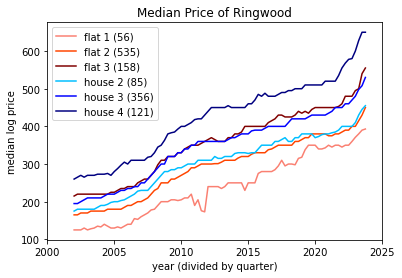

In [51]:
THRESH = 50
SUBURB = 110
plot_suburb(suburbs[SUBURB-1], THRESH)

In [52]:
THRESH = 100
SUBURB = 16

#for i in range(100, 150):
#    plot_difference(suburbs[i-1], THRESH)

#### by average

In [53]:
##

In [54]:
##

## Fitting a model

feat

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder

In [14]:
historic.columns

Index(['suburbs', 'year', 'quarter', 'housing: type', 'housing: beds',
       'housing: count', 'housing: median', 'housing: previous 2 years',
       'housing: avg 2 years', 'economic: median age of earners',
       'economic: median income', 'economic: top 5% suburb',
       'economic: top 1% suburb', 'economic: gini coefficient',
       'economic: trimmed mean quarterly', 'economic: variable interest rate',
       'economic: gdp quarterly', 'economic: gdp per capita quarterly',
       'economic: number of earners', 'economic: net inflation'],
      dtype='object')

In [46]:
features

['quarter',
 'housing: type',
 'housing: beds',
 'economic: median age of earners',
 'economic: median income',
 'economic: gini coefficient',
 'economic: trimmed mean quarterly',
 'economic: variable interest rate',
 'economic: gdp per capita quarterly',
 'economic: number of earners',
 'economic: net inflation']

In [55]:
features = [x for x in historic.columns if not x in ["suburbs", "housing: count", "housing: median", "housing: previous 2 years", "housing: avg 2 years"] + \
                                                    ["economic: top 1% suburb", "economic: top 5% suburb", "economic: gdp quarterly", "year"] + \
                                                    ["economic: median age of earners", "economic: median income", "economic: number of earners"]]
cat_features = ["quarter", "housing: type", "housing: beds"]

# remove all properties
historic_filt = historic[(historic["housing: type"] != "all") & (historic["housing: beds"] != "all")][features + ["housing: median"]]
historic_filt = historic_filt[~historic_filt.isna().any(axis=1)]

# get the train test features
X = historic_filt[features]
y = historic_filt["housing: median"]

# Step 3: One-Hot Encode the categorical features
X = pd.get_dummies(X, columns=cat_features, drop_first=True)

# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [56]:
# train and test
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Predict target values using the test set
y_pred = lin_reg.predict(X_test)

# Calculate evaluation metrics
mse_linear = mean_squared_error(y_test, y_pred)
r2_linear = r2_score(y_test, y_pred)

# baseline data
baseline_pred = [y_train.mean()] * len(y_test)

# baseline score
mse_baseline = mean_squared_error(y_test, baseline_pred)
r2_baseline = r2_score(y_test, baseline_pred)

# Step 9: Print comparison results
print(f"Linear Model - Mean Squared Error: {mse_linear:.2f}, R-squared: {r2_linear:.2f}")
print(f"Baseline Model - Mean Squared Error: {mse_baseline:.2f}, R-squared: {r2_baseline:.2f}")

Linear Model - Mean Squared Error: 0.06, R-squared: 0.72
Baseline Model - Mean Squared Error: 0.22, R-squared: -0.00


In [57]:
# Step 6: Retrieve the predictor names and coefficients
feature_names = X.columns  # Get the column names of the encoded dataframe
coefficients = lin_reg.coef_  # Get the coefficients from the fitted model

# Step 7: Combine predictor names and coefficients into a DataFrame
predictor_df = pd.DataFrame({'Predictor': feature_names, 'Coefficient': coefficients})
predictor_df.sort_values(by="Coefficient")

,Predictor,Coefficient
1,economic: trimmed mean quarterly,-0.068503
5,quarter_2.0,-0.004697
6,quarter_3.0,-0.004481
7,quarter_4.0,-0.001588
3,economic: gdp per capita quarterly,-0.000699
2,economic: variable interest rate,0.006678
8,housing: type_house,0.036464
9,housing: beds_2,0.299728
10,housing: beds_3,0.517044
11,housing: beds_4,0.695693


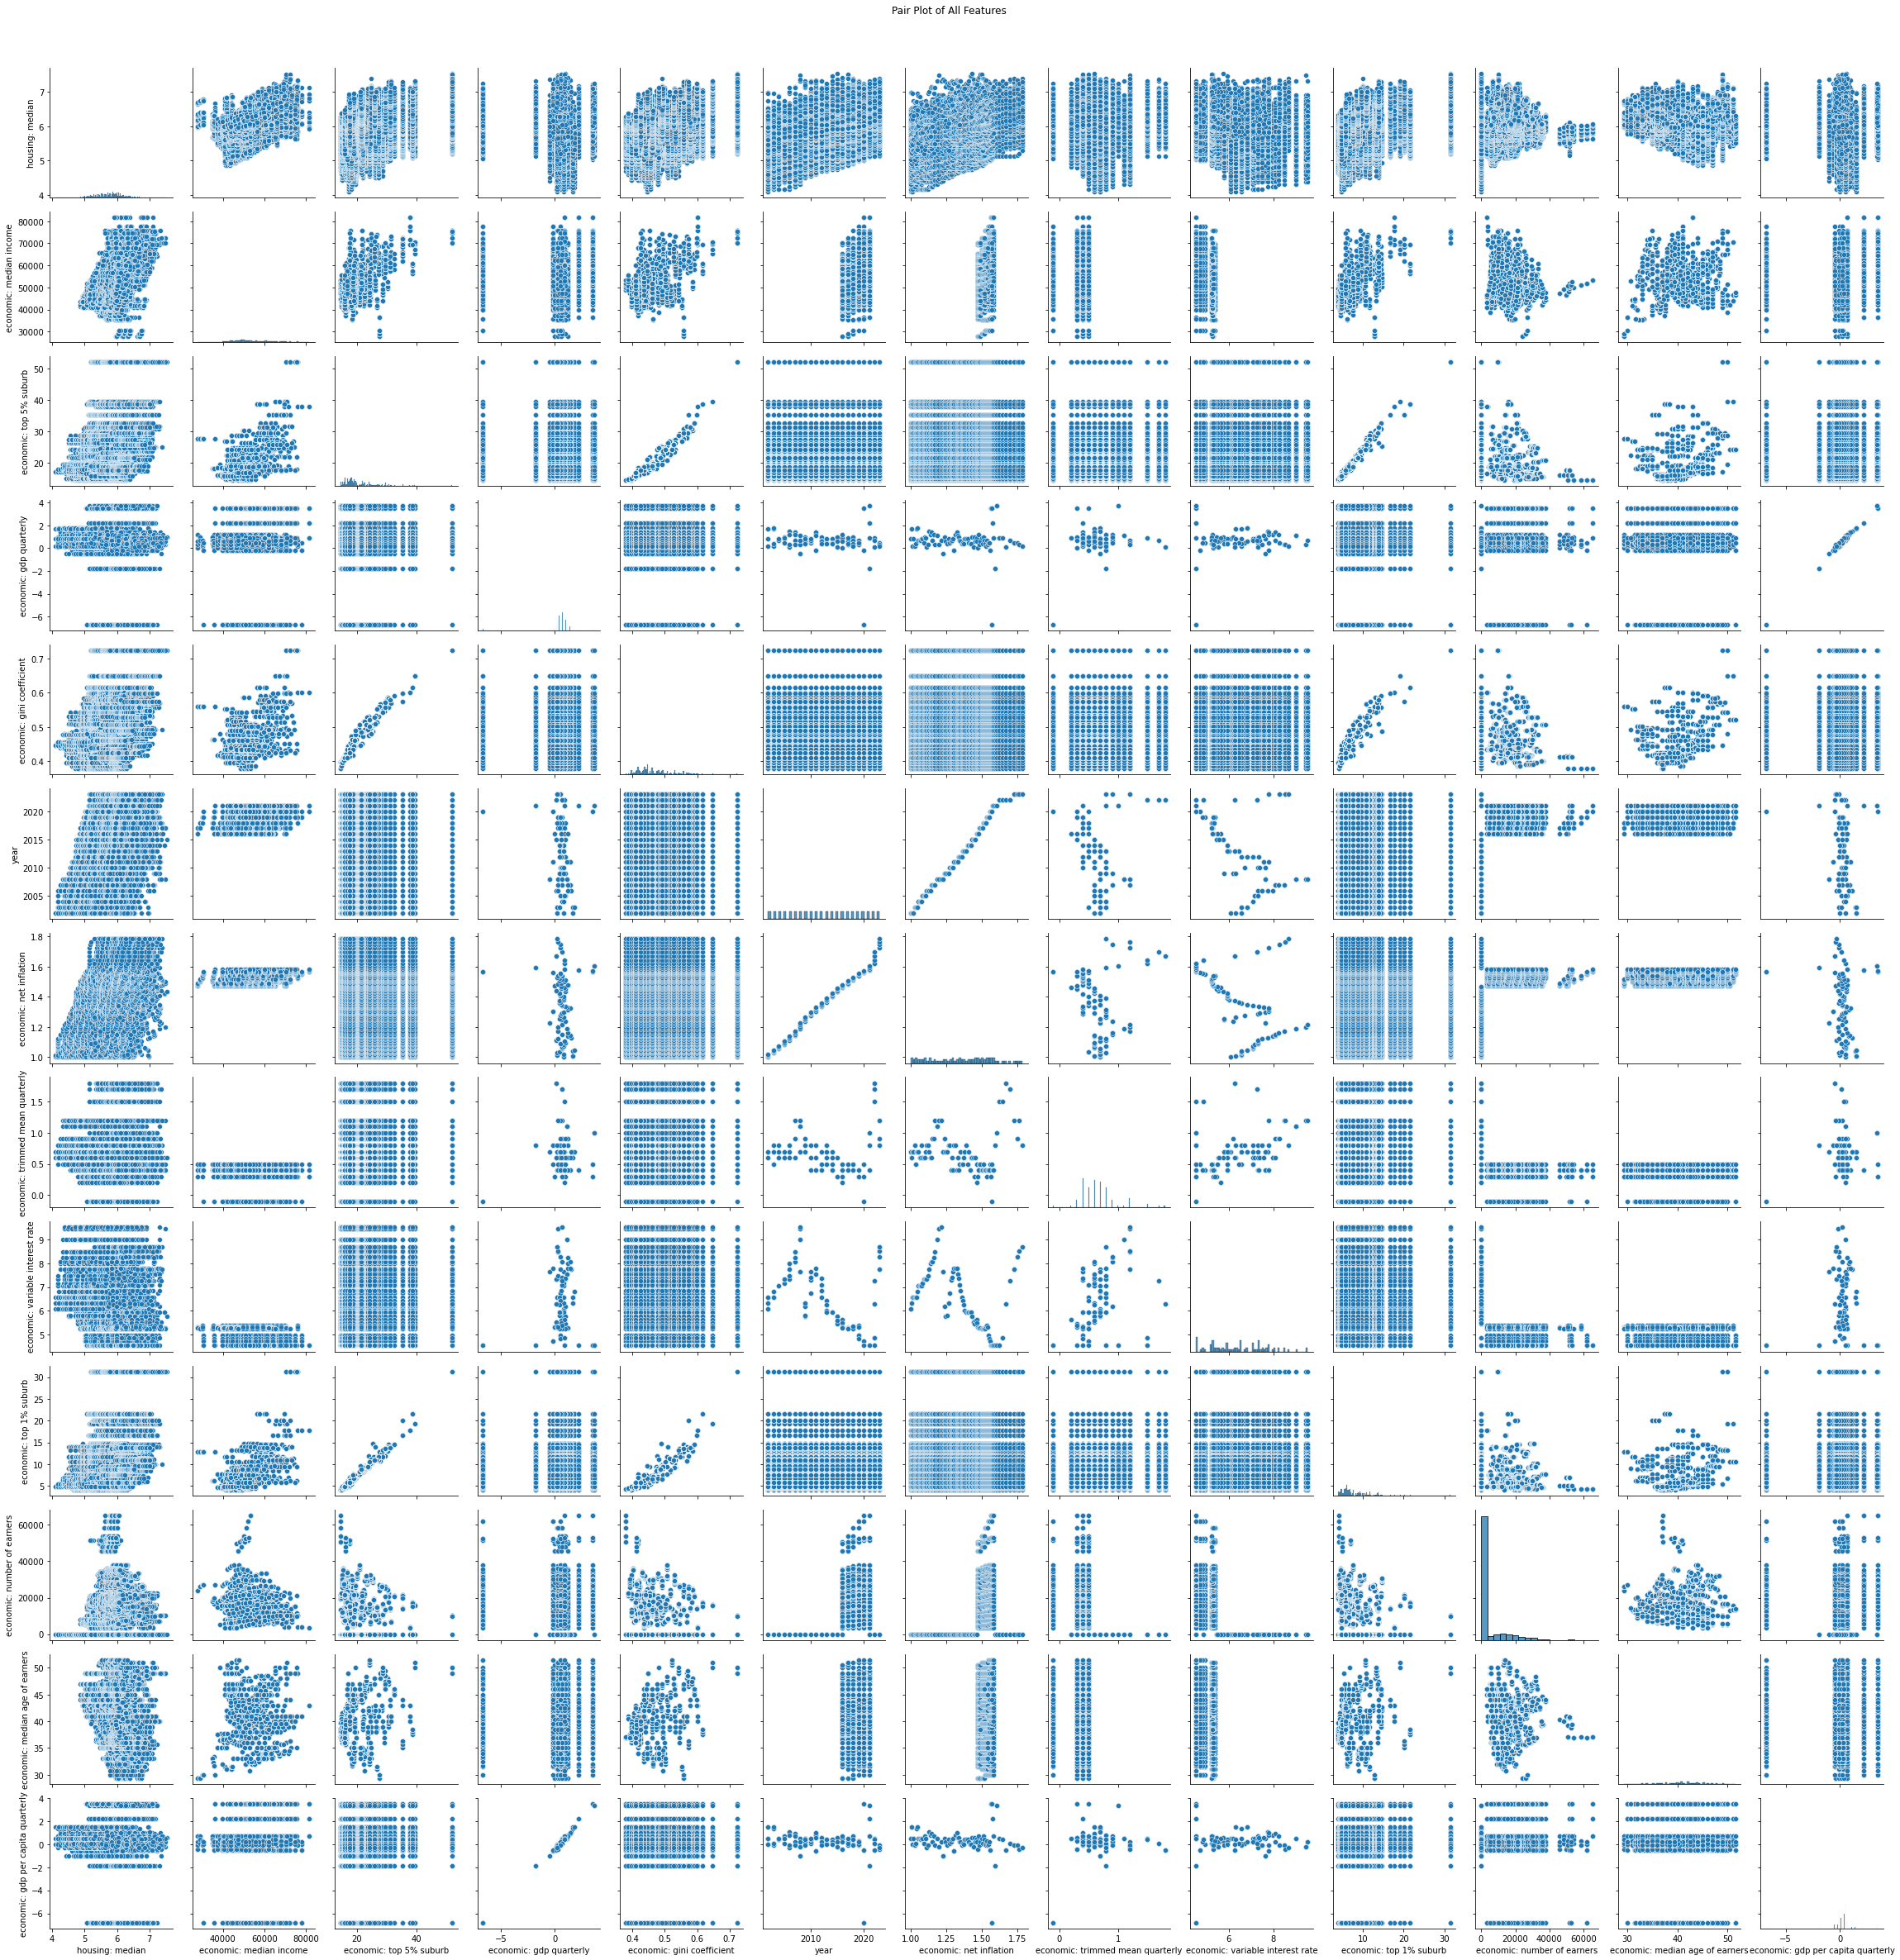

In [124]:
import seaborn as sns

# get the plotting features
features_plot = ["housing: median"] + list(set(features) - set(cat_features))

# Step 4: Create a pair plot
sns.pairplot(historic[features_plot])
plt.suptitle("Pair Plot of All Features", y=1.02)  # Add a title to the plot
plt.savefig("pairplot")
plt.show()